In [62]:
from typing import List, Tuple, Dict, Union, Any
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import torch
import torch.nn as nn
import numpy as np

## Self-Attention

Given three inputs $K, Q, V \in \mathbb{R}^{T \times d}$ ("keys", "queries", "values"):
$$
K=\left[\begin{array}{ccc}
- & k_1^{\top} & - \\
- & k_2^{\top} & - \\
& \vdots & \\
- & k_T^{\top} & -
\end{array}\right], \quad Q=\left[\begin{array}{ccc}
- & q_1^{\top} & - \\
- & q_2^{\top} & - \\
& \vdots & \\
- & q_T^{\top} & -
\end{array}\right], \quad V=\left[\begin{array}{ccc}
- & v_1^{\top} & - \\
- & v_2^{\top} & - \\
& \vdots & \\
- & v_T^{\top} & -
\end{array}\right]
$$
we define the self attention operation as
$$
\underbrace{\operatorname{SelfAttention}(K, Q, V)}_{T \times d}=\underbrace{\operatorname{softmax}\left(\frac{K Q^T}{d^{1 / 2}}\right)}_{T \times T} \underbrace{V}_{T \times d}
$$

By convention, however, it's typical to implement self attention in terms of the actual inputs $X$ rather than the $K, Q$, and $V$ values themselves (i.e., instead of having the linear layer separately). It's also common to have an output weight as well (even though this could in theory be folded into the $W_{K}, W_{Q}, W_{V}$ terms), which applies an additional linear layer to the output of the the entire operation. That is, the full operation is given by

$$
Y=\left(\operatorname{softmax}\left(\frac{X W_K W_Q^T X^T}{\sqrt{d}}\right) X W_V\right) W_o
$$

It's possible to also incorporate bias terms into each of these projections, though we won't bother with this, as it is less common for everything but the output weight, and then just largely adds complexity.

1. $X \in \mathbb{R}^{T \times d}$ : This is our input matrix.
  
2. $W_K \in \mathbb{R}^{d \times d}$ : This is the weight matrix for the "key", which transforms $X$ from $T \times d$ to $T \times d$ again for the keys.
  
3. $W_Q \in \mathbb{R}^{d \times d}$ : This is the weight matrix for the "query", which transforms $X$ from $T \times d$ to $T \times d$ again for the queries.
  
4. $W_V \in \mathbb{R}^{d \times d}$: This is the weight matrix for the "value", again for the same reasons above.
  
5. $W_o \in \mathbb{R}^{d \times d^{\prime}}$: This is the output weight matrix, which transforms the output to have dimensions $T \times d^{\prime}$, where $d^{\prime}$ can be the same as $d$ or different depending on the desired output dimensionality.

In [2]:
def softmax(Z: np.ndarray) -> np.ndarray:
    """
    Apply softmax along the last axis of an array.

    Parameters
    ----------
    Z : np.ndarray
        The input array.

    Returns
    -------
    np.ndarray
        The softmax output.
    """
    # The -1 means the last axis (so the max across the columns in each row)
    Z = np.exp(Z - Z.max(axis=-1, keepdims=True))
    Z /= Z.sum(axis=-1, keepdims=True)
    return Z

We can form:

$$
\begin{aligned}
& K = X W_K \\
& Q = X W_Q \\
& V = X W_V
\end{aligned} \Leftrightarrow 
\begin{align*}
\underbrace{\left[\begin{array}{lll}
K & Q & V
\end{array}\right]}_{T \times 3d} &= X\left[\begin{array}{lll}
W_K & W_Q & W_V \\
\end{array}\right] \\
&= XW_{KQV}
\end{align*}
$$

where $W_{KQV} \in \mathbb{R}^{d \times 3d}$

In [167]:
def self_attention(X: np.ndarray, mask: np.ndarray, W_KQV: np.ndarray, W_out: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Function that performs self attention on the input matrix X. The function returns the output of the self attention
    and the attention weights.

    Parameters
    ----------
    X : np.ndarray
        The input matrix of shape (T x d).
    mask : np.ndarray
        The mask matrix of shape (T x T).
    W_KQV : np.ndarray
        The combined weight matrix of shape (d x 3d).
    W_out : np.ndarray
        The output weight matrix of shape (d x d').

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        The output of the self attention and the attention weights.
    """
    
    # X is T x d so we split along the second axis (columns) XW_KQV (T x 3d) -> XW_K (T x d) | XW_Q (T x d) | XW_V (T x d)
    K, Q, V = np.split(X @ W_KQV, 3, axis=1)
    
    # Scalar value
    d = X.shape[1]
    # Matrix (T x T)
    scaled_matrix = (K @ Q.T) / np.sqrt(d) 
    # Apply softmax to the scaled matrix across the columns in each the row and add the mask
    attn_weights = softmax(scaled_matrix + mask) 
    
    return attn_weights @ V @ W_out, attn_weights

### Reference Implementation with Pytorch

In [168]:
T, d = 100, 64
attn = nn.MultiheadAttention(embed_dim=d, num_heads=1, bias=False, batch_first=True)

In [169]:
# All elements below and including the diagonal are (0) and all elements above the diagonal are (-inf)
mask = torch.triu(input=-np.inf * torch.ones(T, T), diagonal=1)
mask

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [170]:
# Shape (1, T, d)
X = torch.randn(1, T, d)
X.shape

torch.Size([1, 100, 64])

In [171]:
# Output of self-attention layer
Y_torch, A_torch = attn(query=X, key=X, value=X, attn_mask=mask)
Y_torch.shape, A_torch.shape

(torch.Size([1, 100, 64]), torch.Size([1, 100, 100]))

### Custom Implementation

In [172]:
# Get first batch of data [0] and convert to numpy
X = X[0].numpy()
# These are graph so we need to call detach before converting to numpy (also we need to transpose)
W_KQV = attn.in_proj_weight.detach().numpy().T
W_out = attn.out_proj.weight.detach().numpy().T

W_KQV.shape, W_out.shape

((64, 192), (64, 64))

Check implementation:

In [173]:
Y, A = self_attention(X=X, mask=mask.numpy(), W_KQV=W_KQV, W_out=W_out)
Y.shape, A.shape

((100, 64), (100, 100))

In [174]:
np.linalg.norm(A - A_torch[0].detach().numpy())
np.linalg.norm(Y - Y_torch[0].detach().numpy())

2.8810214e-07

1.918466e-06

## Adding Mini-batching

Once we move from single example to minibatches, there is one additional subtlety that comes into play for self-attention. Recall that for each sample in the minibatch, we will have to compute a matrix product, e.g., the $K Q^T$ term. If we need to process examples in a minibatch, we will need to perform this matrix multiplication correspondingly for each sample. This is an operation known as a **batch matrix multiply**.

For CNNs, RNNs, and MLP, we had involved the multiplication of a "batched" tensor by a single weight matrix. In a ConvNet, we have:

$$
y=\operatorname{im} 2 \operatorname{col}(x) W
$$

or in the batched setting

$$
y^{(i)}=\operatorname{im} 2 \operatorname{col}\left(x^{(i)}\right) W
$$

But this operation can be accomplished with "normal" matrix multiplication by just stacking the multiple samples into the matrix on the left:

$$
\left[\begin{array}{c}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(N)}
\end{array}\right]=\left[\begin{array}{c}
\operatorname{im} 2 \operatorname{col}\left(x^{(1)}\right) \\
\operatorname{im} 2 \operatorname{col}\left(x^{(2)}\right) \\
\vdots \\
\operatorname{im} 2 \operatorname{col}\left(x^{(N)}\right)
\end{array}\right] W 
$$

This operation is just a normal matrix multiplication, so it can be implemented where matrix multiplication always operates on 2 dimensional NDArrays.

In [175]:
C = np.random.randn(5, 4, 10, 3)
D = np.random.randn(3, 6)
C.shape, D.shape

((5, 4, 10, 3), (3, 6))

In [176]:
(C @ D).shape

(5, 4, 10, 6)

The operation `C @ D` is a matrix multiplication between a $10 \times 3$ matrix and $3 \times 6$ (the last two dimensions of `C` and `D`) for each input in the leading dimensions of `C`. We can essentially accomplish the same feat by:

* Flatten the first three dimensions of `C` , leaving the last dimension to match the first dimension of `D`

* Conduct the multiplication between the $200 \times 3$ matrix ($5 \times 4 \times 10$) and the $3 \times 6$ matrix

* Reshape the resulting $200 \times 6$ matrix back to $5 \times 4 \times 10 \times 6$

In [177]:
np.linalg.norm((C.reshape(-1, 3) @ D).reshape(5, 4, 10, 6) - (C @ D))

0.0

Re-implement for batch case:

In [221]:
def self_attention_batch(X: np.ndarray, mask: np.ndarray, W_KQV: np.ndarray, W_out: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Function that performs self attention on the input matrix X. The function returns the output of the self attention
    and the attention weights.

    Parameters
    ----------
    X : np.ndarray
        The input matrix of shape (batch x T x d).
    mask : np.ndarray
        The mask matrix of shape (batch x T x T).
    W_KQV : np.ndarray
        The combined weight matrix of shape (batch x d x 3d).
    W_out : np.ndarray
        The output weight matrix of shape (batch x d x d').

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        The output of the self attention and the attention weights.
    """
    
    # X is (batch x T x d) so we split along the last axis (columns) XW_KQV (batch x T x 3d) -> XW_K (batch x T x d) | XW_Q (batch x T x d) | XW_V (batch xT x d)
    K, Q, V = np.split(X @ W_KQV, 3, axis=-1)
    
    # Scalar value, but this time we get 'd' from the last axis of X, which now has a batch dimension (batch x T x d)
    d = X.shape[-1]
    # Matrix (batch x T x T), and we use swapaxes to swap the last two dimensions of Q (batch x T x d) -> (batch x d x T)
    scaled_matrix = (K @ Q.swapaxes(-1, -2)) / np.sqrt(d) 
    # Apply softmax to the scaled matrix across the columns in each the row and add the mask
    attn_weights = softmax(scaled_matrix + mask) 
    
    return attn_weights @ V @ W_out, attn_weights

### Reference Implementation with Pytorch

In [222]:
B, T, d = 50, 100, 64
attn = nn.MultiheadAttention(embed_dim=d, num_heads=1, bias=False, batch_first=True)
attn

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=False)
)

In [223]:
# Add batch dimension with B
mask = torch.triu(input=-np.inf * torch.ones(T, T), diagonal=1)

In [224]:
# Add batch dimension
X = torch.randn(B, T, d)
X.shape

torch.Size([50, 100, 64])

In [225]:
Y_torch, A_torch = attn(query=X, key=X, value=X, attn_mask=mask)
Y_torch.shape, A_torch.shape

(torch.Size([50, 100, 64]), torch.Size([50, 100, 100]))

### Custom Implementation

In [226]:
# Add batch dimension with B
mask = mask.unsqueeze(0).repeat(B, 1, 1)
mask.shape

torch.Size([50, 100, 100])

In [227]:
W_KQV = attn.in_proj_weight.detach().numpy().T
W_out = attn.out_proj.weight.detach().numpy().T

W_KQV.shape, W_out.shape

((64, 192), (64, 64))

In [228]:
Y, A = self_attention_batch(X=X.numpy(), mask=mask.numpy(), W_KQV=W_KQV, W_out=W_out)
Y.shape, A.shape

((50, 100, 64), (50, 100, 100))

Check implementation:

In [229]:
np.linalg.norm(A - A_torch.detach().numpy())
np.linalg.norm(Y - Y_torch.detach().numpy())

1.8201644e-06

1.3360198e-05

## Multi-Head Attention

Practical implementations of attention use what is called **multihead attention**, which simply means that we run the self-attention mechanism of different subsets of the $K, Q, V$ terms, then concatenate them together. Formally, we'll partition these terms as

$$
K = \underbrace{\left[\begin{array}{llll}
K_1 & K_2 & \cdots & K_{\text{heads}}
\end{array}\right]}_{T \times d}
$$

and similarly for $Q$ and $V$.

$$
Q = \underbrace{\left[\begin{array}{llll}
Q_1 & Q_2 & \cdots & Q_{\text{heads}}
\end{array}\right]}_{T \times d}
$$

and 

$$
V = \underbrace{\left[\begin{array}{llll}
V_1 & V_2 & \cdots & V_{\text{heads}}
\end{array}\right]}_{T \times d}
$$

where $K, Q$, and $V$ are partitioned into "heads" matrices, each of $K_{i}, Q_{i}, V_{i}$ will have a dimension of $T \times\left(\frac{d}{\text { heads }}\right)$.

We form the self attention outputs by concatenating the following individual outputs:

$$
Y_i = \operatorname{softmax}\left(\frac{K_i Q_i^T}{\sqrt{d/\text{heads}}}\right) V_i
$$

where each $Y_i$ will have a dimension of $T \times d$. The concatenated matrix of of $Y_{i}$ as given as follows:

$$
Y=\left[\begin{array}{llll}
Y_1 & Y_2 & \cdots & Y_{\text {heads }}
\end{array}\right] W_o 
$$

### High Dimensionality

In the context of attention mechanisms, when we talk about high dimensional hidden states (i.e., where \(d\) is large), we're referring to each individual key, query, and value having many elements or dimensions. This high dimensionality allows these vectors to encode a lot of information. However, there's a potential pitfall: when you calculate the attention weights using a dot product, you boil down these high-dimensional vectors into a single scalar value. This scalar is used to weight the corresponding value vector in the attention output. 

### Potential Information Loss

The dot product \(k_t^T q_s\) is essentially measuring the similarity between two vectors. Now, if both \(k_t\) and \(q_s\) are high-dimensional, then their dot product is condensing all that rich, multi-dimensional information into just one number. This can mean that nuanced relationships or "internal structure" between the vectors might get lost.

### Multi-Head Mechanism

To mitigate this potential information loss, the multi-head attention mechanism was introduced. Instead of performing the attention operation once on the full dimensionality, multi-head attention splits the \(d\) dimensions into multiple "heads". Each head processes a subset of the dimensions independently. This allows the model to:

1. Capture different types of information in different heads. For example, one head might focus on syntactic information while another might focus on semantic information.
2. Reduce the risk of losing nuanced relationships since each head is working with reduced dimensionality.

### Concatenation of Outputs

After processing, the outputs from all the heads are concatenated together and linearly transformed, ensuring that the subsequent layers still receive a high-dimensional input, but one that has been enriched by the multiple "views" or "perspectives" from the multiple heads.

### Advantages

1. **Diversity of Representation**: Each attention head can potentially learn to focus on different aspects of the input data. This allows the model to capture a richer set of patterns and relationships.
2. **Parallelism**: The attention heads can operate in parallel, leading to potential computational benefits.
3. **Flexibility**: By adjusting the number of heads and their dimensionality, one can trade off between model complexity and representational power.

### Heuristic Trade-off

While multi-head attention has proven effective in many applications, there isn't a one-size-fits-all answer to how many heads are optimal or how to divide the dimensionality among them. These decisions often come down to experimentation, domain-specific knowledge, and heuristics.

In summary, multi-head attention provides a mechanism to capture diverse relationships in the data without squashing high-dimensional information into a single scalar, leading to more expressive and powerful models.

In [303]:
def multihead_attention(X: np.ndarray, mask: np.ndarray, heads: int, W_KQV: np.ndarray, W_out: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Multihead attention layer for the transformer model. This

    Parameters
    ----------
    X : np.ndarray
        Input to the multihead attention layer. Shape is (B, T, d)
    mask : np.ndarray
        Mask to apply to the attention weights. Shape is (B, T, T)
    heads : int 
        Number of heads to use in the multihead attention layer
    W_KQV : np.ndarray
        Weights for the K, Q, and V matrices. Shape is (d, 3 * d)
    W_out : np.ndarray
        Weights for the output matrix. Shape is (d, d)

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        Tuple containing the output of the multihead attention layer and the attention weights
    """
    B, T, d = X.shape
    # Each K, Q, V matrix has shape (B x T x d)
    K, Q, V = np.split(X @ W_KQV, 3, axis=-1)
    
    # Convert from (B x T x d) => (B x heads x T x d/heads), since we have 'heads' number of K_i, Q_i, V_i each with dimension (T x d/heads)
    # Note we swap the axes 1 and 2 to go from (T, heads, d/heads) => (heads, T, d/heads)
    K = K.reshape(B, T, heads, d // heads).swapaxes(1, 2)
    Q = Q.reshape(B, T, heads, d // heads).swapaxes(1, 2)
    V = V.reshape(B, T, heads, d // heads).swapaxes(1, 2)

    # K is (B x heads x T x d/heads) and Q is (B x heads x d/heads x T), so K @ Q^T is (B x heads x T x T)
    scaled_matrix = (K @ Q.swapaxes(-1, -2)) / np.sqrt(d // heads) 
    attn_weights = softmax(scaled_matrix + mask) 
    
    return ((attn_weights @ V).swapaxes(1, 2).reshape(B, T, d) @ W_out), attn_weights

### Reference Implementation with Pytorch

In [324]:
heads, B, T, d = 4, 50, 100, 64
attn = nn.MultiheadAttention(embed_dim=d, num_heads=heads, bias=False, batch_first=True)

In [325]:
mask = torch.triu(input=-np.inf * torch.ones(T, T), diagonal=1)
mask.shape

torch.Size([100, 100])

In [326]:
# Add batch dimension
X = torch.randn(B, T, d)
X.shape

torch.Size([50, 100, 64])

In [327]:
Y_torch, A_torch = attn(query=X, key=X, value=X, attn_mask=mask)
Y_torch.shape, A_torch.shape

(torch.Size([50, 100, 64]), torch.Size([50, 100, 100]))

### Custom Implementation

This time we need to add the `batch` dimension and the `heads` dimension to `mask`:

* Unsqueeze to add 0th and 1st dimensions 

* For each `B` and `heads`, repeat the last two dimensions $T \times T$

In [328]:
# Add B and heads dimension to mask
mask = mask.unsqueeze(0).unsqueeze(1).repeat(B, heads, 1, 1)
mask.shape

torch.Size([50, 4, 100, 100])

In [329]:
W_KQV = attn.in_proj_weight.detach().numpy().T
W_out = attn.out_proj.weight.detach().numpy().T

W_KQV.shape, W_out.shape

((64, 192), (64, 64))

In [330]:
Y, A = multihead_attention(X=X.numpy(), mask=mask.numpy(), heads=heads, W_KQV=W_KQV, W_out=W_out) 
Y.shape, A.shape

((50, 100, 64), (50, 4, 100, 100))

A note on the the attention matrix:

In [331]:
# Custom attention matrix shape (B, heads, T, T)
A.shape

(50, 4, 100, 100)

Pytorch's implementation actually returns the average attention over all the heads, so in order to compare the implementations, we have to take the average of the attention over the second axis (`heads`):

In [332]:
np.linalg.norm(A.mean(axis=1) - A_torch.detach().numpy())
np.linalg.norm(Y - Y_torch.detach().numpy())

1.0841064e-06

1.2975037e-05

## Transformer Block

The Transformer architecture uses a series of attention mechanisms (and feedfoward layers) to process the sequence inputs:

$$
Z^{(i+1)}=\text { Transformer }\left(Z^{(i)}\right)
$$

<center>

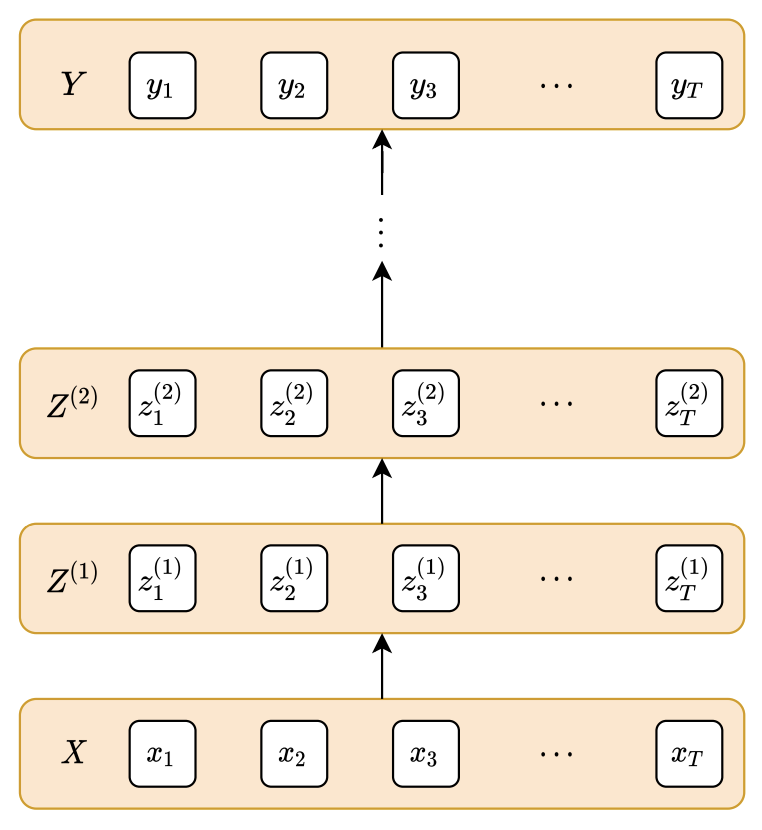

</center>

In more detail, the Transformer block has the following form:

$$
\begin{aligned}
\tilde{Z}:&=\operatorname{SelfAttention}\left(Z^{(i)} W_K, Z^{(i)} W_Q, Z^{(i)} W_V\right) \\
&=\operatorname{softmax}\left(\frac{Z^{(i)} W_K W_Q^T Z^{(i)^T}}{d^{1 / 2}}\right) Z^{(i)} W_V \\
\tilde{Z}:&=\operatorname{LayerNorm}\left(Z^{(i)}+\tilde{Z}\right) \\
Z^{(i+1)}:&=\operatorname{LayerNorm}(\operatorname{ReLU}(\tilde{Z} W)+\tilde{Z})
\end{aligned}
$$

<center>

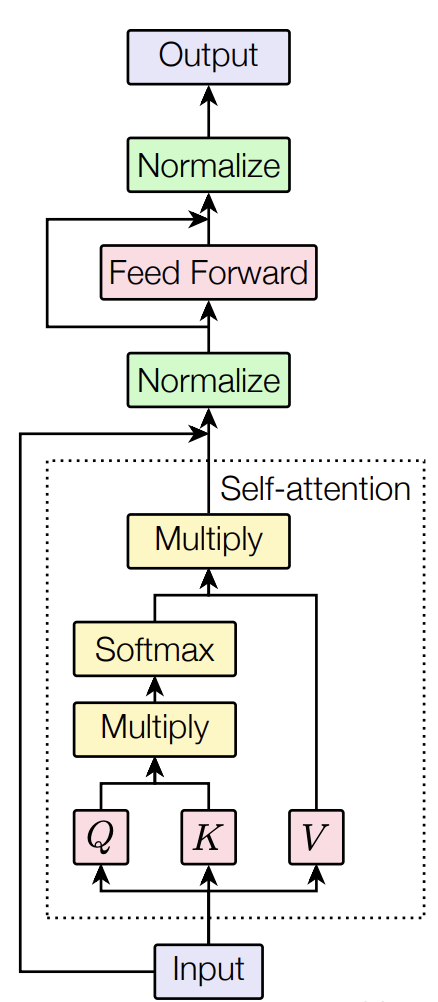

</center>

In [361]:

def layer_norm(Z: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    """
    Apply layer normalization to the input tensor Z.

    Parameters
    ----------
    Z : np.ndarray
        Input tensor to normalize.
    eps : float, optional
        A small number to prevent division by zero in normalization.

    Returns
    -------
    np.ndarray
        Normalized tensor.
    """
    return (Z - Z.mean(axis=-1, keepdims=True)) / np.sqrt(Z.var(axis=-1, keepdims=True) + eps)

def relu(Z: np.ndarray) -> np.ndarray:
    """
    Apply the ReLU activation function element-wise on the input tensor Z.

    Parameters
    ----------
    Z : np.ndarray
        Input tensor.

    Returns
    -------
    np.ndarray
        Tensor with ReLU activation applied.
    """
    return np.maximum(Z, 0)

def transformer(X: np.ndarray, mask: np.ndarray, heads: int, W_KQV: np.ndarray, W_out: np.ndarray, W_ff1: np.ndarray, W_ff2: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    """
    Apply the transformer block on the input tensor X.

    Parameters
    ----------
    X : np.ndarray
        Input tensor.
    mask : np.ndarray
        Attention mask.
    heads : int
        Number of attention heads.
    W_KQV : np.ndarray
        Weight matrix for keys, queries, and values.
    W_out : np.ndarray
        Output weight matrix.
    W_ff1 : np.ndarray
        First feedforward weight matrix.
    W_ff2 : np.ndarray
        Second feedforward weight matrix.
    eps : float, optional
        A small number to prevent division by zero in normalization.

    Returns
    -------
    np.ndarray
        Tensor after applying the transformer block.
    """
    # Note that multihead_attention()[0] returns the attention output and + X is the residual connection
    Z = layer_norm(multihead_attention(X, mask, heads, W_KQV, W_out)[0] + X, eps)
    return layer_norm(Z + relu(Z @ W_ff1) @ W_ff2, eps)

### Reference Implementation with Pytorch

In [372]:
d, heads, dim_feedforward, dropout, eps = 64, 8, 128, 0.0, 1e-6
X = torch.randn(B, T, d)
mask = torch.triu(input=-np.inf * torch.ones(T, T), diagonal=1)

In [373]:
trans = nn.TransformerEncoderLayer(
    d_model=d,
    nhead=heads,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    activation='relu',
    batch_first=True
)

# Remove biases from the transformer since our custom implementation does not use them
trans.linear1.bias.data.zero_()
trans.linear2.bias.data.zero_()

Y_torch = trans(X, mask)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Custom Implementation

In [374]:
# Add B and heads dimension to mask
mask = mask.unsqueeze(0).unsqueeze(1).repeat(B, heads, 1, 1)

W_KQV = trans.self_attn.in_proj_weight.detach().numpy().T
W_out = trans.self_attn.out_proj.weight.detach().numpy().T
W_ff1 = trans.linear1.weight.detach().numpy().T
W_ff2 = trans.linear2.weight.detach().numpy().T

print(f'W_KQV shape: {W_KQV.shape}')
print(f'W_out shape: {W_out.shape}')
print(f'W_ff1 shape: {W_ff1.shape}')
print(f'W_ff2 shape: {W_ff2.shape}')

W_KQV shape: (64, 192)
W_out shape: (64, 64)
W_ff1 shape: (64, 128)
W_ff2 shape: (128, 64)


In [375]:
Y = transformer(
    X=X.numpy(),
    mask=mask.numpy(),
    heads=heads,
    W_KQV=W_KQV,
    W_out=W_out,
    W_ff1=W_ff1,
    W_ff2=W_ff2,
    eps=trans.norm1.eps
)

In [376]:
np.linalg.norm(Y - Y_torch.detach().numpy())

6.402576e-05

## Efficient Transformers

Since the Transformer was first proposed, there have been endless attempts made to make different "efficient" versions of the operation. The key drawback of transformers, we have seen, is that they require forming a the $T \times T$ attention matrix and multiplying by $V$ (an $O\left(T^2 d\right)$ operation)

$$
\operatorname{softmax}\left(\frac{K Q^T}{\sqrt{d}}\right) V
$$

If $T$ is much larger than $d$ (e.g., the sequence is very long, then this operation is quite costly).
There are essentially two approaches to making the approach more efficient: by attempting the represent the attention matrix

$$
A=\operatorname{softmax}\left(\frac{K Q^T}{\sqrt{d}}\right)
$$

either using sparsity or using low rank structure. In general, of course, this matrix neither sparse nor low rank. But we could simply dictate, for example, that we will only compute some subset of the attention weights, thereby decreasing the number of inner products we need to perform (this is the basis of the so-called "Sparse Attention" layer: similar approaches have been proposed a number of times, but this is one such example). Alternatively, one could try to infer some kind of hard sparsity by e.g., triangle inequalities or other similar instances (because, remember, we are computing what amounts to a similarly metric between the $x$ terms at different times).

Alternatively, we could try to represent $A$ in low rank form instead. To see why this could be appealing, consider the case where we don't have a softmax operation at all, but instead used the "attention" layer

$$
\left(\frac{K Q^T}{\sqrt{d}}\right) V
$$

In this case, if $T \gg d$, we could instead perform our multiplication in the order $K\left(Q^T V\right)$, which would only have complexity $O\left(T d^2\right)$, potentially much smaller. And some papers advocate for this very thing, or alternatively try to find a low-rank representation of the actual attention weights, to similar effects.